In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import warnings

warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
df_purpose = pd.read_csv('C:/Users/12489/ALOKPARNA/Masters@WSU/Fall2020/Intelligent_Systems/Project_Tourism/Data/Enter_korea_by_purpose.csv', parse_dates=['date'])
df_purpose

date           nation  visitor     growth      share  tourism  \
0   2019-01-01            China   392814  28.737870  35.555117   320113   
1   2019-01-01            Japan   206526  23.606830  18.693468   198805   
2   2019-01-01           Taiwan    87954  16.003693   7.961057    86393   
3   2019-01-01        Hong Kong    35896   3.533212   3.249086    34653   
4   2019-01-01            Macao     2570 -12.376406   0.232621     2506   
..         ...              ...      ...        ...        ...      ...   
955 2020-04-01   Oceania others       13 -97.239915   0.044195        0   
956 2020-04-01     South Africa       22 -98.101812   0.074792        2   
957 2020-04-01    Africa others      177 -95.412131   0.601734       11   
958 2020-04-01        Stateless        3 -95.312500   0.010199        0   
959 2020-04-01  Overseas Korean      698 -96.540101   2.372939        0   

     business  official affairs  studying  others  
0        2993               138      8793   60777  
1        2233               127       785    4576  
2          74                22       180    1285  
3          59                 2        90    1092  
4           2                 0        17      45  
..        ...               ...       ...     ...  
955         0                 0         0      13  
956         0                 0         0      20  
957         5                 0        11     150  
958         0                 0         0       3  
959         0                 0         0     698  

[960 rows x 10 columns]

In [3]:
# Data Preprocessing
# Adding a filter to the nation column to get the data for China
df_purpose_china = df_purpose.loc[df_purpose['nation'] == 'China']
df_purpose_china

date nation  visitor     growth      share  tourism  business  \
0   2019-01-01  China   392814  28.737870  35.555117   320113      2993   
60  2019-02-01  China   453379  31.284441  37.724933   324291      2694   
120 2019-03-01  China   487623  20.874389  31.753711   369165      3933   
180 2019-04-01  China   493250  34.545722  30.166978   410542      3575   
240 2019-05-01  China   500413  35.165657  33.682331   413949      4034   
300 2019-06-01  China   475007  25.037708  32.177294   395196      3743   
360 2019-07-01  China   519132  26.513573  35.849999   439699      3587   
420 2019-08-01  China   578112  20.908521  36.444075   451570      3625   
480 2019-09-01  China   541350  24.564249  37.087302   432018      3873   
540 2019-10-01  China   567695  19.437542  34.277063   476460      3967   
600 2019-11-01  China   505369  25.012121  34.699185   426849      4020   
660 2019-12-01  China   508877  22.244216  34.929041   433577      3951   
720 2020-01-01  China   481681  22.623175  37.846937   393336      2813   
780 2020-02-01  China   104086 -77.042166  15.190335    49520       715   
840 2020-03-01  China    16595 -96.596756  19.874966     5040       115   
900 2020-04-01  China     3935 -99.202230  13.377528      522        71   

     official affairs  studying  others  
0                 138      8793   60777  
60                143     38731   87520  
120               414     32532   81579  
180               362      9959   68812  
240               534     14003   67893  
300               399     14680   60989  
360               356     10847   64643  
420               388     44291   78238  
480               447     25545   79467  
540               547     12722   73999  
600               545     12822   61133  
660               682     13284   57383  
720                99     10433   75000  
780                11     20753   33087  
840                 2      7388    4050  
900                 0      1112    2230

In [4]:
# Remove irrelevant columns
df_purpose_china = df_purpose_china.drop(columns=['nation', 'visitor', 'growth', 'share'])

# Rename columns for data analysis purpose
df_purpose_china = df_purpose_china.rename(columns = {"official affairs":"official_affairs"})

# Set date as an index for time-series analysis
df_purpose_china = df_purpose_china.set_index('date')

# Plot the no. of visitors from China according to their purpose of visit
fig, ax=plt.subplots(figsize=(15,6))
ax.plot(df_purpose_china.tourism, marker="o", label="Tourism")
ax.plot(df_purpose_china.business, marker="o", label="Business")
ax.plot(df_purpose_china.official_affairs, marker="o", label="Official Affairs")
ax.plot(df_purpose_china.studying, marker="o", label="Studying")
ax.plot(df_purpose_china.others, marker="o", label="Others")
ax.set_xlabel("Date (Month)")
ax.set_ylabel("Number of Visitors")
ax.legend(loc=1)
plt.show()

df_purpose_china

tourism  business  official_affairs  studying  others
date                                                             
2019-01-01   320113      2993               138      8793   60777
2019-02-01   324291      2694               143     38731   87520
2019-03-01   369165      3933               414     32532   81579
2019-04-01   410542      3575               362      9959   68812
2019-05-01   413949      4034               534     14003   67893
2019-06-01   395196      3743               399     14680   60989
2019-07-01   439699      3587               356     10847   64643
2019-08-01   451570      3625               388     44291   78238
2019-09-01   432018      3873               447     25545   79467
2019-10-01   476460      3967               547     12722   73999
2019-11-01   426849      4020               545     12822   61133
2019-12-01   433577      3951               682     13284   57383
2020-01-01   393336      2813                99     10433   75000
2020-02-01    49520       715                11     20753   33087
2020-03-01     5040       115                 2      7388    4050
2020-04-01      522        71                 0      1112    2230

In [5]:
# Group the visitor data for 'business', 'official_affairs', 'studying' and 'others'  into 'non_tourism'
df_purpose_china['non_tourism'] = df_purpose_china['business'] + df_purpose_china['official_affairs'] + df_purpose_china['studying'] + df_purpose_china['others']
df_purpose_china = df_purpose_china.drop(columns=['business', 'official_affairs', 'studying', 'others'])

# Plot the no. of visitors from China according to their purpose of visit: 'tourism' & 'non_tourism'
fig, ax=plt.subplots(figsize=(15,6))
ax.plot(df_purpose_china.tourism, marker="o", label="Tourism")
ax.plot(df_purpose_china.non_tourism, marker="o", label="Non-Tourism")
ax.set_xlabel("Date (Month)")
ax.set_ylabel("Number of Visitors")
ax.legend(loc=1)
plt.show()

# Plot the no. of visitors from China in the year 2020 according to their purpose of visit: 'tourism' & 'non_tourism'
fig, ax=plt.subplots(figsize=(15,6))
ax.plot(df_purpose_china.tourism[13:], marker="o", label="Tourism")
ax.plot(df_purpose_china.non_tourism[13:], marker="o", label="Non-Tourism")
ax.set_xlabel("Date (Month)")
ax.set_ylabel("Number of Visitors")
ax.legend(loc=1)
plt.show()

df_purpose_china

tourism  non_tourism
date                            
2019-01-01   320113        72701
2019-02-01   324291       129088
2019-03-01   369165       118458
2019-04-01   410542        82708
2019-05-01   413949        86464
2019-06-01   395196        79811
2019-07-01   439699        79433
2019-08-01   451570       126542
2019-09-01   432018       109332
2019-10-01   476460        91235
2019-11-01   426849        78520
2019-12-01   433577        75300
2020-01-01   393336        88345
2020-02-01    49520        54566
2020-03-01     5040        11555
2020-04-01      522         3413

### Time Series Forcasting using ARIMA

In [6]:
# Find p ,q, d parameter combinations for Seasonal ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
# Visitor data for purpose 'tourism'
dfTourism = df_purpose_china['tourism']

# Training Dataset: Tourist data for the year 2019
train = dfTourism['2019-01-01':'2020-01-01']

# Find the optimal value of p, d, q for best ARIMA model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:346.56391768865797
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:27.24710013942077
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:312.84992578720943
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:34.90027025587474
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:262.9075392159796
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:240.21773604362392
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(0, 1,

In [8]:
# Fitting the ARIMA model on training data (2019 data) based on lowest AIC score
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:                  tourism   No. Observations:                   13
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                  Thu, 17 Dec 2020   AIC                              2.000
Time:                          00:15:01   BIC                               -inf
Sample:                      01-01-2019   HQIC                               nan
                           - 01-01-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.124e+08         -0       -inf      0.000    4.12e+08    4.12e+08
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                       

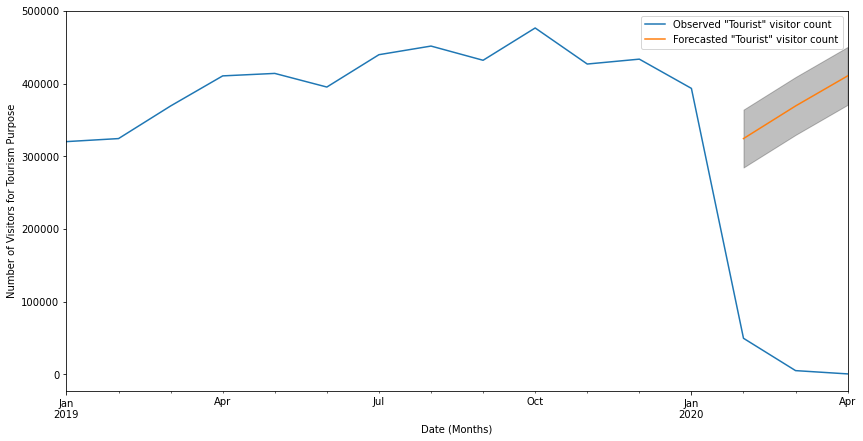

In [9]:
# Forcast 'tourist' visitor count for 2020
pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()
ax = dfTourism.plot(label='Observed "Tourist" visitor count', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted "Tourist" visitor count')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date (Months)')
ax.set_ylabel('Number of Visitors for Tourism Purpose')
plt.legend()
plt.show()

Mean absolute error (MAE) between expected and predicted values: 349638.667


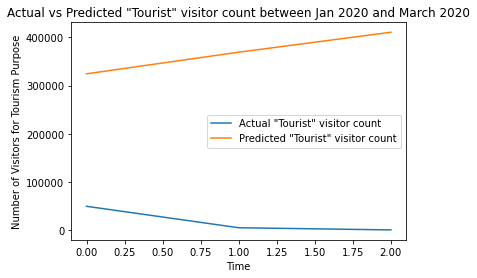

In [10]:
# Actual vs Predicted 'Tourist' visitor count between Jan 2020 and March 2020
dfTourism_true = df_purpose_china['tourism'][13:].values
dfTourism_pred = pred_uc.predicted_mean.values

# Calculate the mean absolute error between expected and predicted values
mae = mean_absolute_error(dfTourism_true, dfTourism_pred)
print('Mean absolute error (MAE) between expected and predicted values: %.3f' % mae)

# Plot the expected and predicted visitor count for 'Tourism' between Jan 2020 and March 2020
plt.plot(dfTourism_true, label='Actual "Tourist" visitor count')
plt.plot(dfTourism_pred, label='Predicted "Tourist" visitor count')
plt.xlabel('Time')
plt.ylabel('Number of Visitors for Tourism Purpose')
plt.title('Actual vs Predicted "Tourist" visitor count between Jan 2020 and March 2020');
plt.legend()
plt.show()

In [11]:
# Visitor data for purpose 'non_tourism'
dfNonTourism = df_purpose_china['non_tourism']

# Training Dataset: Tourist data for the year 2019
train = dfNonTourism['2019-01-01':'2020-01-01']

# Find the optimal value of p, d, q for best ARIMA model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:311.7166749824875
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:25.565342961729147
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:279.2330927092579
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:30.68141151577473
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:251.95972928696148
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:227.09184945166413
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(0, 1,

In [12]:
# Fitting the ARIMA model on training data (2019 data) based on lowest AIC score
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:              non_tourism   No. Observations:                   13
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                  Thu, 17 Dec 2020   AIC                              2.000
Time:                          00:15:04   BIC                               -inf
Sample:                      01-01-2019   HQIC                               nan
                           - 01-01-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.883e+07         -0       -inf      0.000    1.88e+07    1.88e+07
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                       

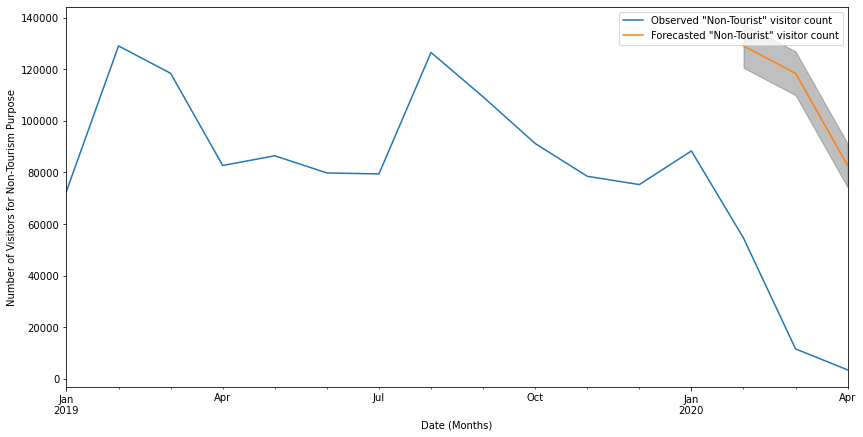

In [13]:
# Forcast 'non_tourist' visitor count for 2020
pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()
ax = dfNonTourism.plot(label='Observed "Non-Tourist" visitor count', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted "Non-Tourist" visitor count')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date (Months)')
plt.ylabel('Number of Visitors for Non-Tourism Purpose')
plt.legend()
plt.show()

Mean absolute error (MAE) between expected and predicted values: 86906.667


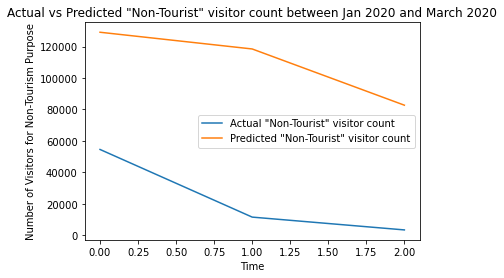

In [14]:
# Actual vs Predicted 'Non-Tourist' visitor count between Jan 2020 and March 2020
dfNonTourism_true = df_purpose_china['non_tourism'][13:].values
dfNonTourism_pred = pred_uc.predicted_mean.values

# Calculate the mean absolute error between expected and predicted values
mae = mean_absolute_error(dfNonTourism_true, dfNonTourism_pred)
print('Mean absolute error (MAE) between expected and predicted values: %.3f' % mae)

# Plot the expected and predicted visitor count for 'Tourism' between Jan 2020 and March 2020
plt.plot(dfNonTourism_true, label='Actual "Non-Tourist" visitor count')
plt.plot(dfNonTourism_pred, label='Predicted "Non-Tourist" visitor count')
plt.xlabel('Time')
plt.ylabel('Number of Visitors for Non-Tourism Purpose')
plt.title('Actual vs Predicted "Non-Tourist" visitor count between Jan 2020 and March 2020');
plt.legend()
plt.show()

### Time Series Modeling with Prophet

In [15]:
# Reset index and flatten dataset
df_purpose_china = df_purpose_china.reset_index()

# Training Dataset: Visitor data for the year 2019
df_purpose_china2019 = df_purpose_china[:13]
print(df_purpose_china2019)

# Prepare the dataset for modeling with Prophet
dfTourism = df_purpose_china2019.drop(columns=['non_tourism'])
dfTourism = dfTourism.rename(columns={'date': 'ds', 'tourism': 'y'})
print(dfTourism)

dfNonTourism = df_purpose_china2019.drop(columns=['tourism'])
dfNonTourism = dfNonTourism.rename(columns={'date': 'ds', 'non_tourism': 'y'})
print(dfNonTourism)

         date  tourism  non_tourism
0  2019-01-01   320113        72701
1  2019-02-01   324291       129088
2  2019-03-01   369165       118458
3  2019-04-01   410542        82708
4  2019-05-01   413949        86464
5  2019-06-01   395196        79811
6  2019-07-01   439699        79433
7  2019-08-01   451570       126542
8  2019-09-01   432018       109332
9  2019-10-01   476460        91235
10 2019-11-01   426849        78520
11 2019-12-01   433577        75300
12 2020-01-01   393336        88345
           ds       y
0  2019-01-01  320113
1  2019-02-01  324291
2  2019-03-01  369165
3  2019-04-01  410542
4  2019-05-01  413949
5  2019-06-01  395196
6  2019-07-01  439699
7  2019-08-01  451570
8  2019-09-01  432018
9  2019-10-01  476460
10 2019-11-01  426849
11 2019-12-01  433577
12 2020-01-01  393336
           ds       y
0  2019-01-01   72701
1  2019-02-01  129088
2  2019-03-01  118458
3  2019-04-01   82708
4  2019-05-01   86464
5  2019-06-01   79811
6  2019-07-01   79433
7  2019-08-0

In [16]:
# Forcast 'Tourist' visitor count
dfTourism_model = Prophet(interval_width=0.95)
dfTourism_model.fit(dfTourism)
dfTourism_forecast = dfTourism_model.make_future_dataframe(periods=3, freq='MS')
dfTourism_forecast = dfTourism_model.predict(dfTourism_forecast)

# Forcast 'Non-Tourist' visitor count
dfNonTourism_model = Prophet(interval_width=0.95)
dfNonTourism_model.fit(dfNonTourism)
dfNonTourism_forecast = dfNonTourism_model.make_future_dataframe(periods=3, freq='MS')
dfNonTourism_forecast = dfNonTourism_model.predict(dfNonTourism_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


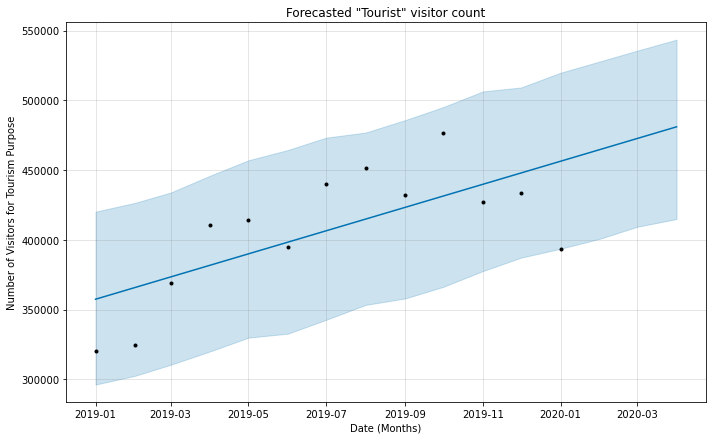

In [17]:
# Forecasted 'Tourist' visitor count
dfTourism_model.plot(dfTourism_forecast, xlabel = 'Date (Months)', ylabel = 'Number of Visitors for Tourism Purpose')
plt.title('Forecasted "Tourist" visitor count');

Mean absolute error (MAE) between expected and predicted values: 454415.307


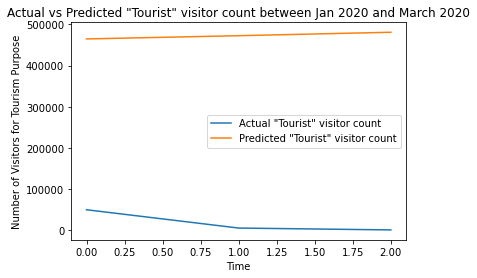

In [18]:
# Actual vs Predicted 'Tourist' visitor count between Jan 2020 and March 2020
dfTourism_true = df_purpose_china['tourism'][13:].values
dfTourism_pred = dfTourism_forecast['yhat'][13:].values

# Calculate the mean absolute error between expected and predicted values
mae = mean_absolute_error(dfTourism_true, dfTourism_pred)
print('Mean absolute error (MAE) between expected and predicted values: %.3f' % mae)

# Plot the expected and predicted 'Tourist' visitor count between Jan 2020 and March 2020
plt.plot(dfTourism_true, label='Actual "Tourist" visitor count')
plt.plot(dfTourism_pred, label='Predicted "Tourist" visitor count')
plt.xlabel('Time')
plt.ylabel('Number of Visitors for Tourism Purpose')
plt.title('Actual vs Predicted "Tourist" visitor count between Jan 2020 and March 2020');
plt.legend()
plt.show()

In [19]:
# Forecasted 'Non-Tourist' visitor count
dfNonTourism_model.plot(dfNonTourism_forecast, xlabel = 'Date (Months)', ylabel = 'Number of Visitors for Non-Tourism Purpose')
plt.title('Forecasted "Non-Tourist" visitor count');

In [20]:
# Actual vs Predicted 'Non-Tourist' visitor count between Jan 2020 and March 2020
dfNonTourism_true = df_purpose_china['non_tourism'][13:].values
dfNonTourism_pred = dfNonTourism_forecast['yhat'][13:].values

# Calculate the mean absolute error between expected and predicted values
mae = mean_absolute_error(dfNonTourism_true, dfNonTourism_pred)
print('Mean absolute error (MAE) between expected and predicted values: %.3f' % mae)

# Plot the expected and predicted 'Non-Tourist' visitor count between Jan 2020 and March 2020
plt.plot(dfNonTourism_true, label='Actual "Non-Tourist" visitor count')
plt.plot(dfNonTourism_pred, label='Predicted "Non-Tourist" visitor count')
plt.xlabel('Time')
plt.ylabel('Number of Visitors for Non-Tourism Purpose')
plt.title('Actual vs Predicted "Non-Tourist" visitor count between Jan 2020 and March 2020');
plt.legend()
plt.show()

Mean absolute error (MAE) between expected and predicted values: 61045.460
